In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x +5  # d/dx : 6x-4 ?

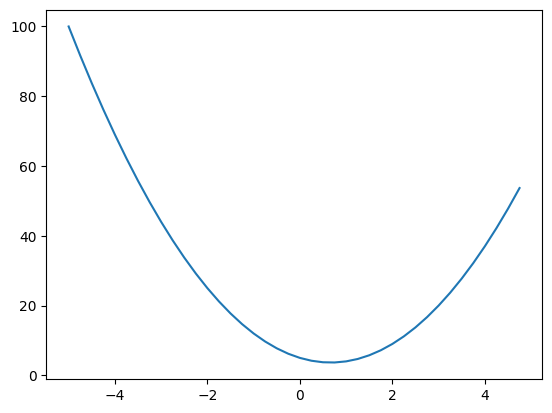

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [4]:
h = 0.00001
x = 3.0
f(x), f(x +h), f(x + h) - f(x), (f(x + h) - f(x))/h

(20.0, 20.0001400003, 0.0001400003000000538, 14.00003000000538)

In [5]:
h = 0.00001
x = -3.0
f(x), f(x +h), f(x + h) - f(x), (f(x + h) - f(x))/h

(44.0, 43.9997800003, -0.00021999970000052826, -21.999970000052823)

In [6]:
h = 0.00001
x = 2/3
f(x), f(x +h), f(x + h) - f(x), (f(x + h) - f(x))/h

(3.666666666666667,
 3.666666666966667,
 3.000000248221113e-10,
 3.0000002482211127e-05)

In [7]:
class Value:
    
    def __init__(self, data, _children=(), _op=(), label=None):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        return out

In [8]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
a,b,c

(Value(data=2.0, label=a),
 Value(data=-3.0, label=b),
 Value(data=10.0, label=c))

In [9]:
d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(-2.0, label = 'f')
L = e*f; L.label = 'L'
L

Value(data=-8.0, label=L)

In [10]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [11]:
trace(L)

({Value(data=-2.0, label=f),
  Value(data=-3.0, label=b),
  Value(data=-6.0, label=d),
  Value(data=-8.0, label=L),
  Value(data=10.0, label=c),
  Value(data=2.0, label=a),
  Value(data=4.0, label=e)},
 {(Value(data=-2.0, label=f), Value(data=-8.0, label=L)),
  (Value(data=-3.0, label=b), Value(data=-6.0, label=d)),
  (Value(data=-6.0, label=d), Value(data=4.0, label=e)),
  (Value(data=10.0, label=c), Value(data=4.0, label=e)),
  (Value(data=2.0, label=a), Value(data=-6.0, label=d)),
  (Value(data=4.0, label=e), Value(data=-8.0, label=L))})

In [12]:
from graphviz import Digraph

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

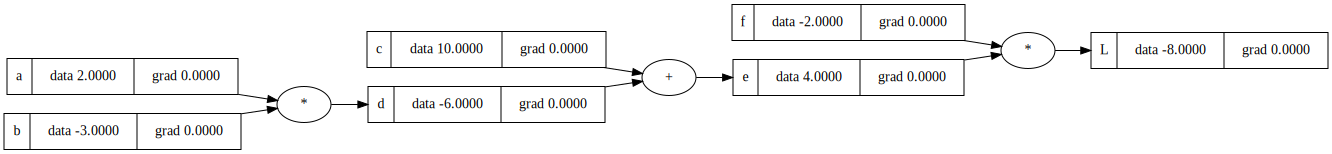

In [13]:
draw_dot(L)

In [14]:
 # manual backprop - just watched it, I think I can do it myself as well

In [15]:
# dL/ dL is obv 1
L.grad = 1.0

# dL/de = -2.0, the value of f, given L = f*e - simple calculus
# dL/df = 4.0, the value of e, same reasoning as above
e.grad = -2.0
f.grad = 4.0

# dL/dc = dL/de * de/dc, chain rule stuff, de/dc = 1.0, given e = c + d - simple calculus
# dL/dd = dL/de * de/dd, chain rule stuff, same reasoning as above
c.grad = -2.0 * 1.0
d.grad = -2.0 * 1.0
# check that out, a add node always redistributes gradients to children does not change it

# using chain rule similary
# dL/da = dL/dd * dd/da,
# dL/db = dL/dd * dd/db
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

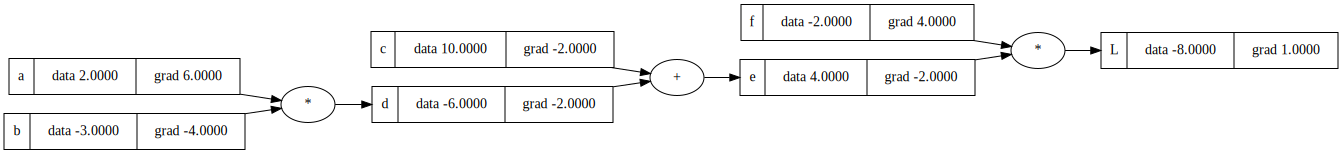

In [16]:
draw_dot(L)

Time for neuron

In [17]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

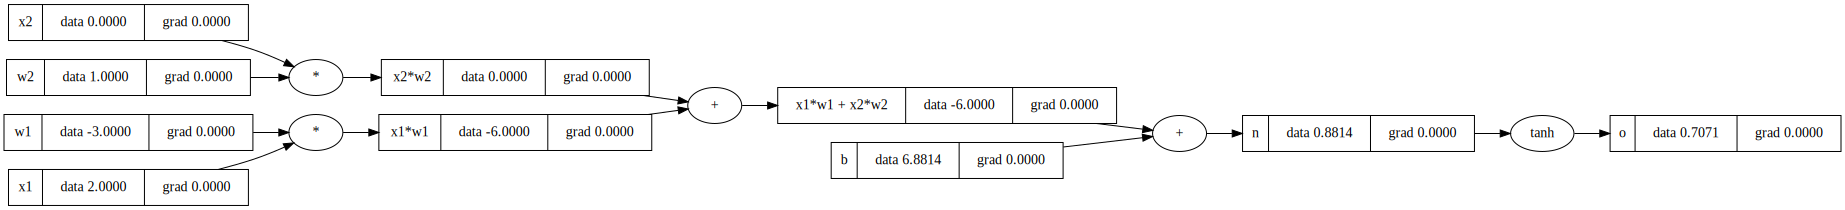

In [18]:
draw_dot(o)

In [19]:
# some more backprop time

In [20]:
# some math that'll be useful below
1 - o.data**2

0.4999999999999999

In [21]:
# do/do = 1.0 obv
o.grad = 1.0

# o = tanh(n), remember that
# do/dn = 1 - (tanh(n))**2 given calculus rules
#       = 1 - o**2
n.grad = 0.5 # from above

# x1w1x2w2 and b will just get the gradient redistributed from n, because of the + node
x1w1x2w2.grad = 0.5
b.grad = 0.5

# more + nodes when backprop on next step, so
x1w1.grad = 0.5
x2w2.grad = 0.5

# now it's the multiplication nodes out to leaves finally, chain rule rules
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

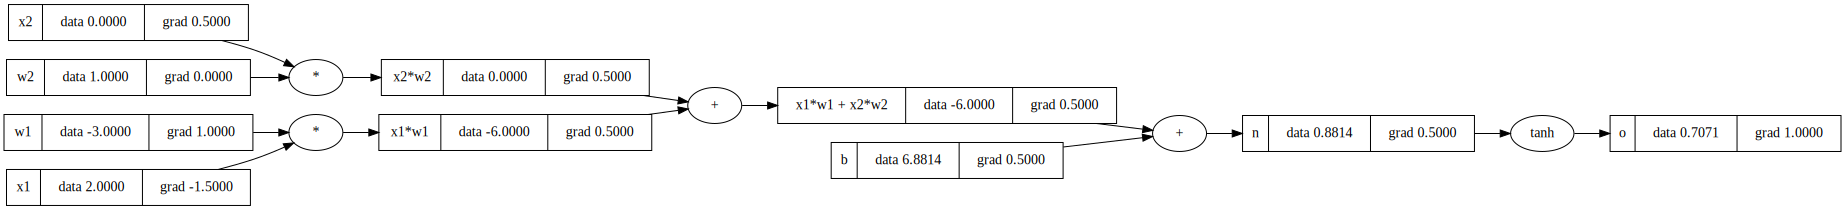

In [22]:
draw_dot(o)